In [1]:
import sys, os
sys.path.append("lib") # adding "lib" path with own packages
from Sigma_mol import sigma_mol # reads the radio sounsing and compute extinction coefficient
from scipy.interpolate import interp1d # to interpolate modeled variables to lidar heights
from lidar_integrating_space_time import Lidar_space_time as lidar_integ #integrates lidar raw data in height and time
from lidar_integrating_space_time_std import Lidar_space_time2 as lidar_integ_std #maybe not used
from fft_denoising import fft_denoising #maybe not used
from klett import Klett81b #maybe not used
import numpy as np 
import pylab #plots
from DP_simp import DP_simp # Curve simplification
from running_mean import running_mean # runing mean
from time2epoch import time2epoch #maybe not used?
#from cloud_mask_v1 import cloud_mask
from netCDF4 import Dataset 
#from time import sleep
from scipy import stats
from scipy.optimize import curve_fit
from dplots import densplot # make 2D desity plots
from Comb_LidarMRR import Comb_LidarMRR3 as Comb_LidarMRR 
from cloud_mask_v2 import cloud_mask2
from sm_paramTOP import sm_paramTOP
import matplotlib
from copy import copy
from BG_corr import BG_corr
import time
from calendar import timegm

In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
        
pylab.rc('font', **font)      

## Routine to get parameters

In [88]:
TRES = 5#10
VRES = 3#6

def CalSys(year, month, day, hour, TRES=TRES, VRES=VRES, rlim=4, doshow=True, rlimmax=7):

    path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
    filename1 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
    filename2 = path_in+"Par10_bc/Par10bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
    filename3 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

    filenameSNR = path_in+"SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
    
    r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
    Mat_Spar = np.loadtxt(filename1)
    Mat_Spar10 = np.loadtxt(filename2)
    Mat_Sper = np.loadtxt(filename3)
    SNR_Spar = np.loadtxt(filenameSNR)

    pix_r = np.squeeze(np.where((r >= rlim)&(r <= rlimmax)))[0]
    
    #SNR_par2 = np.ma.masked_where(~(SNR_par>30),SNR_par)
    #pix_r2 = np.squeeze(np.where(r >= 0.3))[0]
    
    Spar = Mat_Spar[int((60./TRES)*hour),:]
    Spar10 = Mat_Spar10[int((60./TRES)*hour),:]
    Sper = Mat_Sper[int((60./TRES)*hour),:]
    
    SNR_Spar2 = SNR_Spar[int((60./TRES)*hour),:]
    
    #pixK = np.where(~(SNR_Spar2>30))
    
    r_sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[2]
    sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[3]

    f_sm = interp1d(r_sm, sm, fill_value='extrapolate')

    sm_lidar = f_sm(r[int(11*3./VRES):])#/100000
    sm_lidar[np.isnan(sm_lidar)] = 0
    bm = sm_lidar/((8*np.pi/3)*1.0401)
    bm_par = 0.996*bm
    bm_per =0.00366*bm_par
    T2 = np.exp((-2*np.cumsum(sm_lidar)*(r[1]-r[0])))  
    

    Cpar_ = Spar[int(11*3./VRES):]/(bm_par*T2)
    Cper_ = Sper[int(11*3./VRES):]/(bm_per*T2)
    
    pix = np.squeeze(np.where((r[int(11*3./VRES):]>rlim) & (r[int(11*3./VRES):]<rlimmax) & (SNR_Spar2[int(11*3./VRES):]>10)))
    
    #print pix, Cpar_
    
    Cpar = np.nanmedian(Cpar_[pix])#np.nanmean(Cpar_[pix_r:])
    Cper = np.nanmedian(Cper_[pix])# np.nanmean(Cper_[pix_r:])
    Cpar_std = np.nanstd(Cpar_[pix])#np.nanstd(Cpar_[pix_r:])
    Cper_std = np.nanstd(Cper_[pix])#np.nanstd(Cper_[pix_r:])  
    
    K = np.nanmedian((0.00366/(Sper/Spar)))#[pixK])
    #pylab.plot(r[pixK],(0.00366/(Sper/Spar))[pixK])
    #pylab.show()

    pix = np.where((r>0.3) & (SNR_Spar2>30))
    CC = (0.00366/(Sper/Spar))[pix]  
    
    K2 = np.nanmedian(CC)
    
    if doshow == True:
        
        pylab.plot(r[int(11*3./VRES):],1/(bm_par*T2))
        pylab.plot(r[int(11*3./VRES):],1/(bm_per*T2))
        #pylab.axis([3,10,1,0.01])
        pylab.show()
        
        pylab.plot(r[:],Spar)
        pylab.plot(r[:],Sper)
        pylab.axis([3,10,1,1000])
        pylab.xlabel("Range [km]")
        pylab.ylabel("r2-corrected Signal")
        pylab.show()

        pylab.plot(r[:],0.00366/(((Sper))/(Spar)))
        pylab.axis([3,10,0,1])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Dep.Ratio")
        pylab.show()

        pylab.plot(r[int(11*3./VRES):][pix_r:],Cpar_[pix_r:])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Cpar")
        pylab.show()

        pylab.plot(r[int(11*3./VRES):][pix_r:],Cper_[pix_r:])
        pylab.xlabel("Range [km]")
        pylab.ylabel("Cper")
        pylab.show()    
    
        print "Cpar = ", Cpar,'/std = ',Cpar_std,"Cper = ",Cper,'/std = ',Cper_std,"Cpar/Cper = ", Cpar/Cper
    return [[Cpar,Cper], [Spar,Spar10, Sper], r, K, SNR_Spar2, K2, [r[int(11*3./VRES):],sm_lidar]]


dates = np.zeros(shape = (29,4)) 

dates[0,:] = np.array([2017,2,25,14]) #[YYYY,M,D,H]

dates[1,:] = np.array([2017,3,8,14]) #[YYYY,M,D,H]
dates[2,:] = np.array([2017,3,18,13]) #[YYYY,M,D,H]
dates[3,:] = np.array([2017,3,20,16]) #[YYYY,M,D,H]
dates[4,:] = np.array([2017,3,21,14]) #[YYYY,M,D,H]
dates[5,:] = np.array([2017,3,24,12]) #[YYYY,M,D,H]

dates[6,:] = np.array([2017,4,6,10]) #[YYYY,M,D,H]
dates[7,:] = np.array([2017,4,9,19]) #[YYYY,M,D,H]
#dates[7,:] = np.array([2017,4,10,12]) #[YYYY,M,D,H]
dates[8,:] = np.array([2017,4,11,11]) #[YYYY,M,D,H]
dates[9,:] = np.array([2017,4,18,13]) #[YYYY,M,D,H]

dates[10,:] = np.array([2017,5,2,8]) #[YYYY,M,D,H]
dates[11,:] = np.array([2017,5,3,8]) #[YYYY,M,D,H]
dates[12,:] = np.array([2017,5,4,10]) #[YYYY,M,D,H]
dates[13,:] = np.array([2017,5,7,12]) #[YYYY,M,D,H]
dates[14,:] = np.array([2017,5,11,13]) #[YYYY,M,D,H]
dates[15,:] = np.array([2017,5,22,18]) #[YYYY,M,D,H]
dates[16,:] = np.array([2017,5,23,8]) #[YYYY,M,D,H]

dates[17,:] = np.array([2017,6,1,14]) #[YYYY,M,D,H]
dates[18,:] = np.array([2017,6,6,8]) #[YYYY,M,D,H]
dates[19,:] = np.array([2017,6,11,11]) #[YYYY,M,D,H]
dates[20,:] = np.array([2017,6,12,18]) #[YYYY,M,D,H]
dates[21,:] = np.array([2017,6,13,14]) #[YYYY,M,D,H]
dates[22,:] = np.array([2017,6,18,18]) #[YYYY,M,D,H]

dates[23,:] = np.array([2017,7,9,14]) #[YYYY,M,D,H]
dates[24,:] = np.array([2017,7,10,16]) #[YYYY,M,D,H]
dates[25,:] = np.array([2017,7,18,15]) #[YYYY,M,D,H]

dates[26,:] = np.array([2017,8,9,10]) #[YYYY,M,D,H]
dates[27,:] = np.array([2017,8,14,14]) #[YYYY,M,D,H]
dates[28,:] = np.array([2017,8,22,10]) #[YYYY,M,D,H]

Cs = np.zeros(shape = (np.shape(dates)[0], 2))
CCs = np.zeros(shape = (np.shape(dates)[0]))
Ks = np.zeros(shape = (np.shape(dates)[0]))

epoch_time = []

for i in range(np.shape(dates)[0]):
    Cs[i,:],P,r,Ks[i], SNR, CCs[i], sigma = CalSys(int(dates[i,0]), int(dates[i,1]), int(dates[i,2]),int(dates[i,3]), TRES = TRES, VRES = VRES, doshow = False)
    utc_time = time.strptime(str(int(dates[i,0]))+"-"+str(int(dates[i,1])).zfill(2)+"-"+str(int(dates[i,2])).zfill(2)+" "+str(int(dates[i,3])).zfill(2)+":00:00", "%Y-%m-%d %H:%M:%S")
    epoch_time.append(timegm(utc_time))
epoch_time = np.array(epoch_time)

doy = 31+dates[0,2]+dates[0,3]/24.+(epoch_time-epoch_time[0])/(3600.*24)

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: divide by zero encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: divide by zero encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:48: RuntimeWarning: invalid value encountered in greater
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: invalid value encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: invalid value encountered in divide


## Save Parameters

In [9]:
filename = "I:/PHD/Lidar/Processing_V3/Calibration_sys/CalSys_"+str(TRES)+"min_"+str(VRES)+"bins_1.csv"
if os.path.isfile(filename) == False: 
    txt = open(filename,"w")
    txt.write('timestamp,EPOCH_time,DOY,Cpar,Cper,K'+"\n")
    for i in range(np.shape(dates)[0]):
        txt.write(str(int(dates[i,0]))+"-"+str(int(dates[i,1])).zfill(2)+"-"+str(int(dates[i,2])).zfill(2)+" "+str(int(dates[i,3])).zfill(2)+":00:00"+","+str(epoch_time[i])+","+str(doy[i])+","+str(Cs[i,0])+","+str(Cs[i,1])+","+str(CCs[i])+"\n")
    txt.close()    

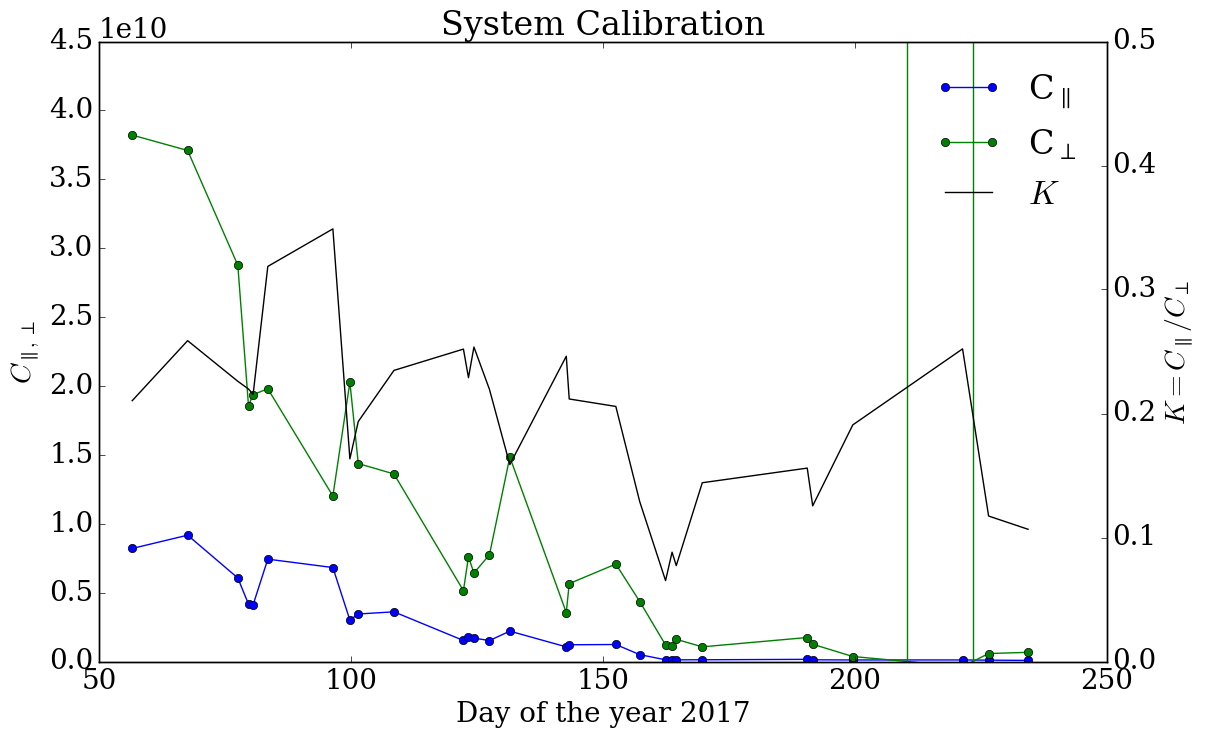

In [89]:
# PLots
fig, ax1 = pylab.subplots(figsize=(13,8))
ax1.plot(doy,Cs[:,0], "-o", label = r'$C_{\parallel}$')
ax1.plot(doy,Cs[:,1], "-o", label = r'$C_{\perp}$')
ax1.set_xlabel("Day of the year 2017")
ax1.set_ylabel(r'$C_{\parallel,\perp}$')
#pylab.show()
pylab.axis([50,250,0,4.5e10])
ax2 = ax1.twinx()
ax2.plot(doy,Cs[:,0], "-o", label = "C"+r'$_{\parallel}$', color = "blue")
ax2.plot(doy,Cs[:,1], "-o", label = "C"+r'$_{\perp}$', color = "green")
ax2.plot(doy, CCs, "-", color = 'black', label = r'$K$')
pylab.axis([50,250,0,0.5])
ax2.set_ylabel(r'$K = C_{\parallel}/C_{\perp}$')
ax2.legend(frameon = False)
pylab.title("System Calibration")
pylab.savefig("plots/System_calibration"+str(TRES)+"min_"+str(VRES)+"bins_3.png",format="png",bbox_inches = 'tight', dpi=900)
pylab.show()

## Following codes are only for tests

In [ ]:
#Overlapping correction

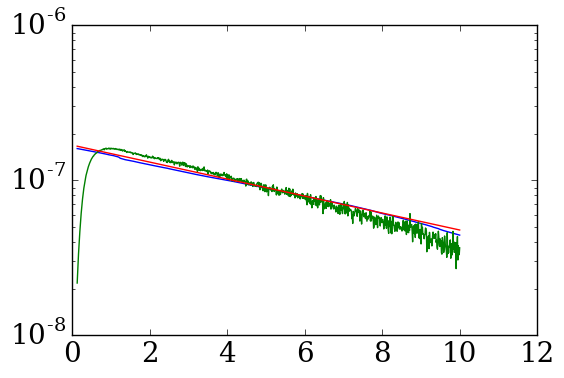

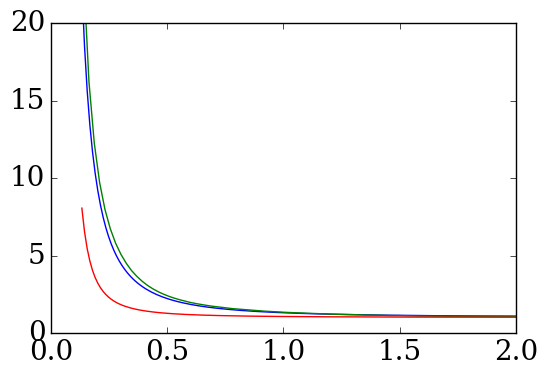

In [180]:
##### output Temporal RESolution
TRES = 5 #min. 

##### output Temporal resolution
VRES = 3 #bins, 1bin = 3.8m # try only 1,2,3,6 bins

year = 2017
month = 3
day  = 21
hour = 14
path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"

filename = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
Par = np.loadtxt(filename)

Spar = Par[60/TRES*14,:]

r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")

r_sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[2]
sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[3]

f_sm = interp1d(r_sm, sm, fill_value='extrapolate')

sm_lidar = f_sm(r[int(11*3./VRES):])#/100000

C,P,r,K, SNR, CC, sigma = CalSys(year, month, day,hour, TRES = TRES, VRES = VRES, doshow = False)

B = P[0][int(11*3./VRES):]/C[0]
Bm = 0.996*sm_lidar/((8*np.pi/3)*1.0401)*np.exp(-2*np.cumsum(sm_lidar)*(r[1]-r[0]))

O = np.loadtxt(path_in+"Overlapping_"+str(TRES)+"min_"+str(VRES)+"_08032017_14UTC.dat")
O3 = np.loadtxt("C:/Users/duran/Documents/PhD/CODES/Python27/Notebooks/LIDAR/OverlapCorrBr_15min-6pix.txt")
r3 = np.loadtxt("C:/Users/duran/Documents/PhD/CODES/Python27/Notebooks/LIDAR/r_15min-6pix.txt")

f_0 = interp1d(r3[3:]/1000.,O3, fill_value='extrapolate')
O4 =f_0(r[int(11*3./VRES):])

pylab.plot(r[int(11*3./VRES):],Bm)
pylab.plot(r[int(11*3./VRES):],B)
line_Bm = np.exp(lm[0]*r[int(11*3./VRES):])*np.exp(lm[1]) 
pylab.plot(r[int(11*3./VRES):],line_Bm)
pylab.yscale("log")
pylab.show()

O5 = (line_Bm/B)
O2 = (Bm/B)

#pix_lin = np.where((r[int(11*3./VRES):]>4) & (r[int(11*3./VRES):]<7))

#X = r[int(11*3./VRES):][pix_lin]
#Y = np.log(B[pix_lin])

x = r[int(11*3./VRES):]
p = np.polyfit(1/x**2, O5, 2)
O5_fit = p[0]/x**4+p[1]/x**2+p[2]
p = np.polyfit(1/x**2, O2, 2)
O2_fit = p[0]/x**4+p[1]/x**2+p[2]

#pylab.plot(1/x**2,O2)
#pylab.plot(1/x**2,O2_fit)
#pylab.plot(x,O2)
#pylab.plot(x,O2_fit)
#pylab.show()


#pylab.plot(1/x**2,O5)
#pylab.plot(1/x**2,O5_fit)
#pylab.show()



#pylab.plot(r[int(11*3./VRES):],O2)
#pylab.plot(r[int(11*3./VRES):],O2_fit)
pylab.plot(r[int(11*3./VRES):],O)
pylab.plot(r3[3:]/1000.,O3)
#pylab.plot(r[int(11*3./VRES):],O4)
#pylab.plot(x,O5)
pylab.plot(x,O5_fit)
pylab.axis([0,2,0,20])
pylab.show()




#np.savetxt(path_in+"Overlapping_"+str(TRES)+"min_"+str(VRES)+"_08032017_14UTC.dat",O5_fit)
#np.savetxt(path_in+"Overlapping_"+str(TRES)+"min_"+str(VRES)+"_08032017_14UTC_r.dat",r[int(11*3./VRES):])



In [162]:
O5

array([ 24.18956824,  18.91183578,  15.30356728,  12.73795789,
        10.85917343,   9.40710167,   8.30635154,   7.38647762,
         6.66376999,   6.06703731,   5.55266104,   5.10250875,
         4.70975873,   4.36712055,   4.06946747,   3.81253339,
         3.58332571,   3.37997593,   3.2046921 ,   3.04788542,
         2.90963542,   2.78987829,   2.67596504,   2.57825646,
         2.48614706,   2.40508865,   2.32782607,   2.26305278,
         2.20014493,   2.14421625,   2.08739039,   2.03754623,
         1.9927726 ,   1.94831934,   1.91574178,   1.87218768,
         1.83949751,   1.80043588,   1.78255515,   1.74820482,
         1.71430177,   1.69941993,   1.67392369,   1.65520331,
         1.62666276,   1.59839726,   1.58547949,   1.5650324 ,
         1.54759711,   1.52696282,   1.5166874 ,   1.49856708,
         1.48621114,   1.4663742 ,   1.45609196,   1.44161965,
         1.42857067,   1.41432814,   1.4021745 ,   1.39634236,
         1.37570463,   1.36655132,   1.36276459,   1.35

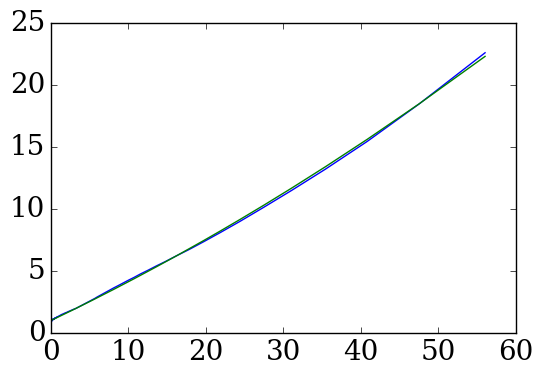

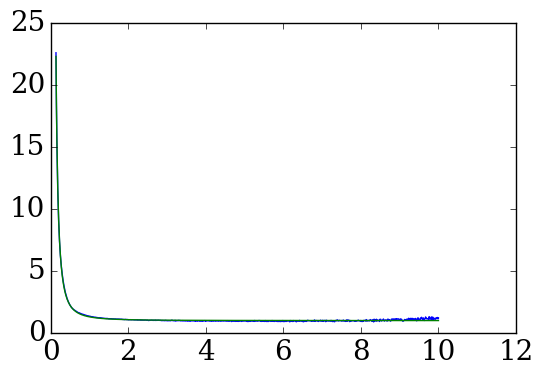

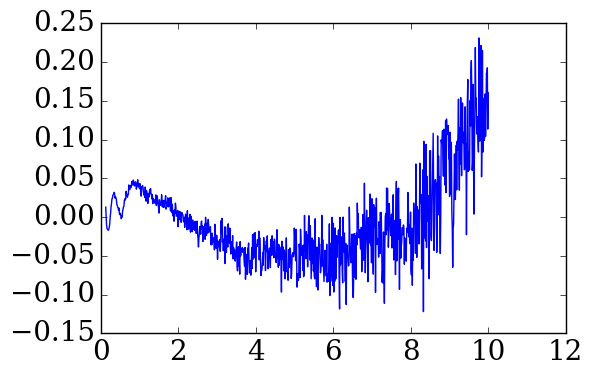

In [158]:
x = r[int(11*3./VRES):]
p = np.polyfit(1/x**2, O5, 2)
O5_fit = p[0]/x**4+p[1]/x**2+p[2]
pylab.plot(1/x**2,O5)
pylab.plot(1/x**2,O5_fit)
pylab.show()

pylab.plot(x,O5)
pylab.plot(x,O5_fit)
pylab.show()

pylab.plot(x,(O5-O5_fit)/O5)

pylab.show()


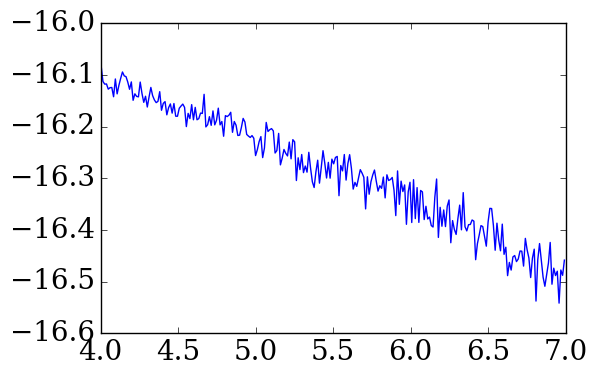

LinregressResult(slope=-0.12611387799202672, intercept=-15.592614119378679, rvalue=-0.97549990636070183, pvalue=5.4267872330573141e-173, stderr=0.0017638894116076482)


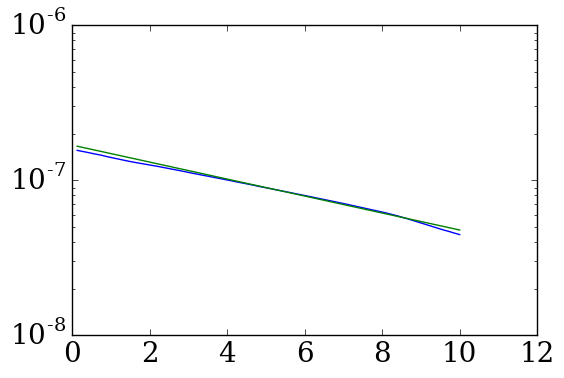

In [110]:
pylab.plot(X,Y)
lm = stats.linregress(x = X, y = Y)
pylab.show()
print lm

pylab.plot(r[int(11*3./VRES):],Bm)
#pylab.plot(r[int(11*3./VRES):],B)
pylab.plot(r[int(11*3./VRES):],np.exp(lm[0]*r[int(11*3./VRES):])*np.exp(lm[1]))
pylab.yscale("log")
pylab.show()



#y = np.exp(lm[0]*x)*np.exp(lm[1])


In [122]:
print 237/2.
for i in range(900):
    print r[int(11*3./VRES):][i], O2[i],O5[i]
    
 


 118.5
0.133590170987 21.2786265421 22.6351972772
0.145040757072 17.4164894046 18.5124988023
0.156491343157 14.5658587304 15.4890723259
0.167941929241 12.4620166365 13.2577849654
0.179392515326 10.8382282406 11.5353425287
0.190843101411 9.55287098163 10.1664412751
0.202293687495 8.50547115417 9.04775229747
0.21374427358 7.65771348263 8.14286025134
0.225194859665 6.95577521447 7.39567765387
0.236645445749 6.3707405357 6.77312047093
0.248096031834 5.89957189155 6.27216793909
0.259546617918 5.47366461527 5.81841511125
0.270997204003 5.12305843316 5.44304893608
0.282447790088 4.79642292696 5.09521900671
0.293898376172 4.52000680003 4.80087797115
0.305348962257 4.25115269391 4.51398153948
0.316799548342 4.02885416558 4.27652266455
0.328250134426 3.81574953828 4.04870636149
0.339700720511 3.62656586885 3.84724944091
0.351151306596 3.45982768002 3.67003178962
0.36260189268 3.2948813884 3.49471224889
0.374052478765 3.13544011923 3.32524025185
0.385503064849 3.01287221287 3.19530417793
0.396953

IndexError: index 863 is out of bounds for axis 0 with size 863

In [ ]:
np.shape(P[O])

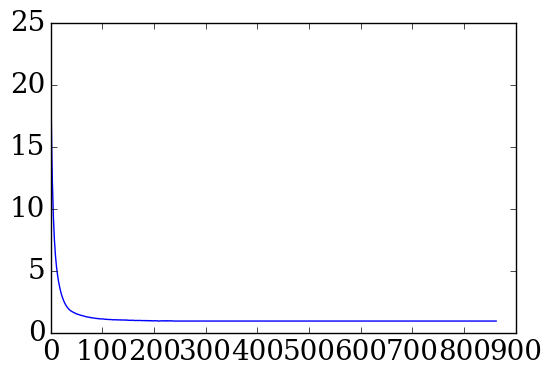

In [71]:

O = (Bm/B)
O[237:] = 1

pylab.plot(O)
pylab.show()

In [ ]:
# fig = pylab.figure(figsize=(20,5))

ax = fig.add_subplot(2,2, 1)
pylab.plot(r,P1[0]/C1[0])
pylab.plot(r,P2[0]/C2[0])
pylab.plot(r,P3[0]/C3[0])
#pylab.plot(r,P4[0])
#pylab.plot(r,P5[0])
pylab.plot(r,P[0]/C[0], color = "black")
#pylab.axis([0.5,10,0,0.05])

ax = fig.add_subplot(2,2, 2)
pylab.plot(r,CC1*P1[2]/C1[0])
pylab.plot(r,CC2*P2[2]/C2[0])
pylab.plot(r,CC3*P3[2]/C3[0])
#pylab.plot(r,P4[0])
#pylab.plot(r,P5[0])
pylab.plot(r,CC*P[2]/C[0], color = "black")
#pylab.axis([0.5,10,0,0.0005])

ax = fig.add_subplot(2,2, 3)
#pylab.plot(r,P1[1]/P1[0])
pylab.plot(r,P2[2]/P2[0])
pylab.plot(r,P3[2]/P3[0])
#pylab.plot(r,P4[1]/P4[0])
#pylab.plot(r,P5[1]/P5[0])
pylab.plot(r,P[2]/P[0], color = "black")
pylab.axis([0.5,6,0.00,0.03])

ax = fig.add_subplot(2,2, 4)
#pylab.plot(r,K1*P1[1]/P1[0])
pylab.plot(r,CC2*P2[2]/P2[0])
pylab.plot(r,CC3*P3[2]/P3[0])
#pylab.plot(r,K4*P4[1]/P4[0])
#pylab.plot(r,K5*P5[1]/P5[0])
pylab.plot(r,CC*P[2]/P[0], color = "black")
pylab.axis([0.5,6,0.000,0.01])
pylab.show()

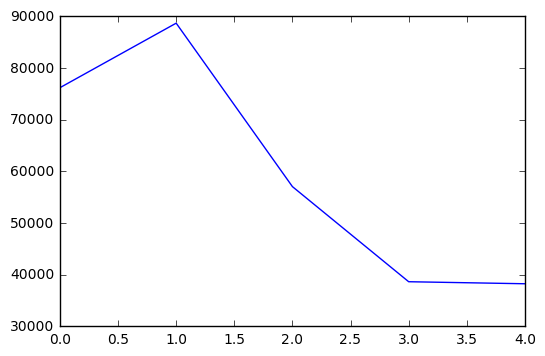

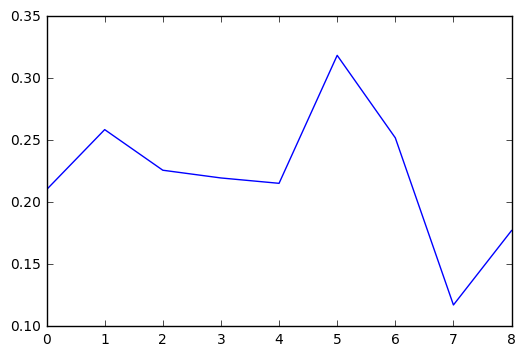

[76210.411937161145, 88699.626342925025, 57062.639244255013, 38655.448271098394, 38262.604938485078, nan, nan, nan, nan]


NameError: name 'version' is not defined

In [827]:
pylab.plot(Cs)
pylab.show()

pylab.plot(CCs)
pylab.show()

print Cs

np --version

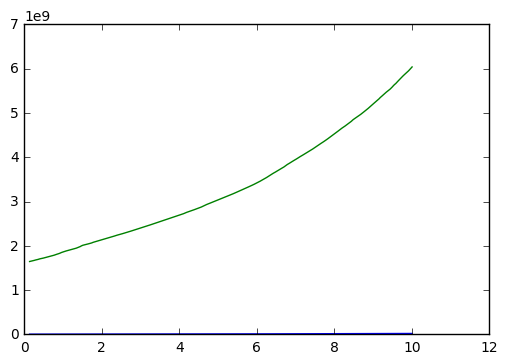

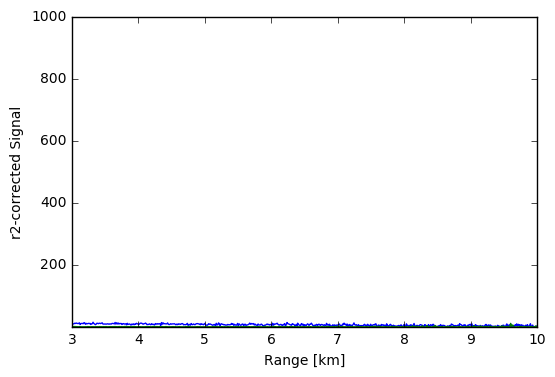

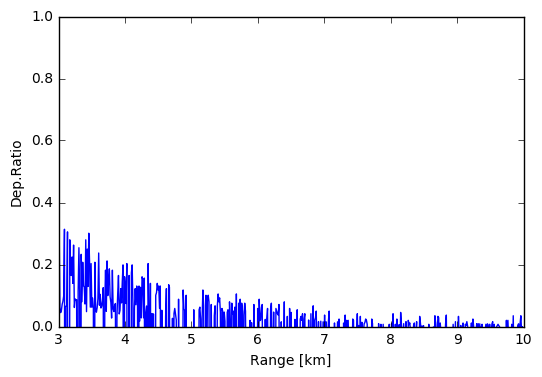

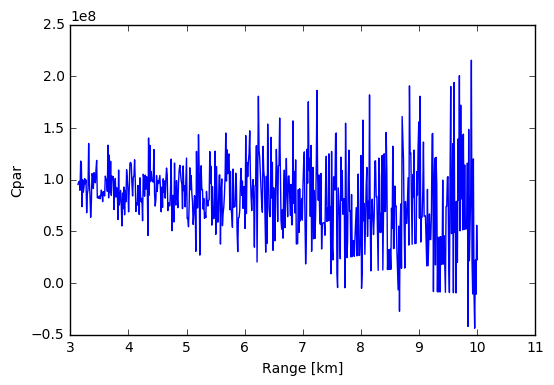

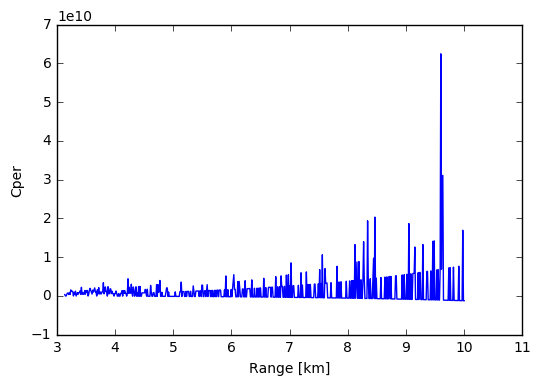

Cpar =  nan /std =  nan Cper =  nan /std =  nan Cpar/Cper =  nan


In [874]:
C,P,r,K, SNR, CC, sigma= CalSys(year, month, day,hour, TRES = 5, VRES = 3, doshow = True)

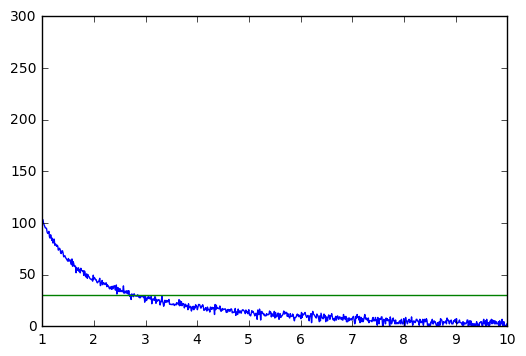

(array([], dtype=int64),)

In [876]:
pylab.plot(r,SNR)
pylab.plot(r,SNR*0+30)

pylab.axis([1,10,0,300])
pylab.show()

np.where((r[int(10*3./VRES):]>5) & (SNR[int(10*3./VRES):]>30))

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in divide


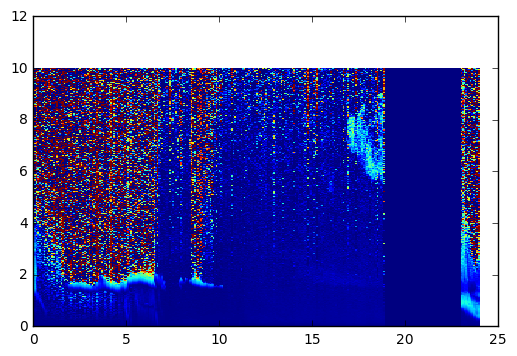

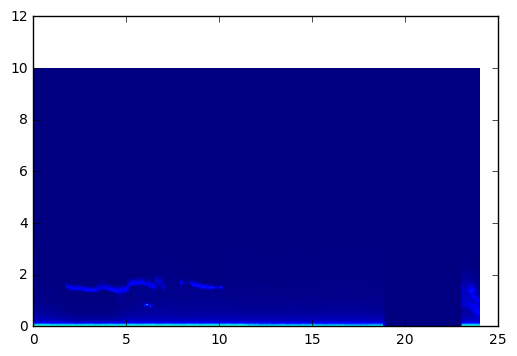

In [451]:
path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
filename1 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
filename3 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
filenameSNR = path_in+"SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
Mat_Spar = np.loadtxt(filename1)
Mat_Sper = np.loadtxt(filename3)
SNR_par = np.loadtxt(filenameSNR)
hours = np.linspace(0,24,np.shape(Mat_Spar)[0])

pylab.pcolor(hours,r,K*np.transpose(Mat_Sper/Mat_Spar), vmin = 0, vmax = 0.1)
pylab.show()
pylab.pcolor(hours,r,np.transpose(SNR_par),vmin = 0, vmax = 10000)
pylab.show()

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


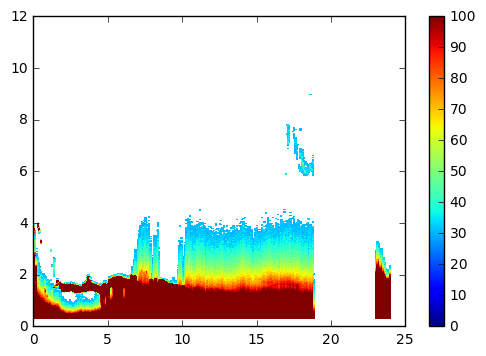

In [485]:
SNR_par2 = np.ma.masked_where(~((SNR_par>30) & (r>0.3)),SNR_par)
#SNR_par2 = np.ma.masked_where(~(((SNR_par2) < 0) & ((SNR_par2) >= 0)),SNR_par2)

pylab.pcolor(hours,r,np.transpose(SNR_par2),vmin = 0, vmax = 100)
pylab.colorbar()
pylab.show()



[295479.38326833793, 1283266.9893993114]
[387222.20356238307, 1856049.0951779026]
[244875.14589933, 1475818.3965653554]
0.230255578698 0.208627134147 0.165924985397


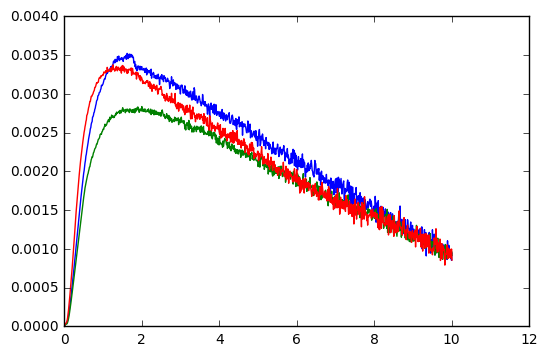

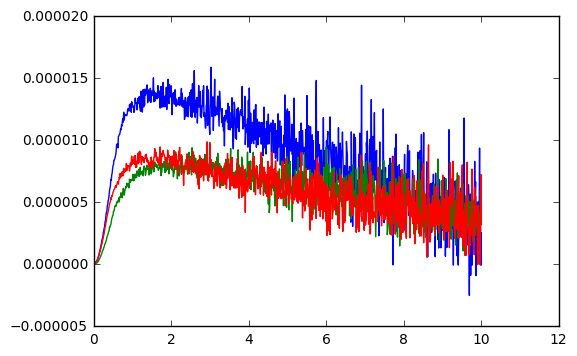

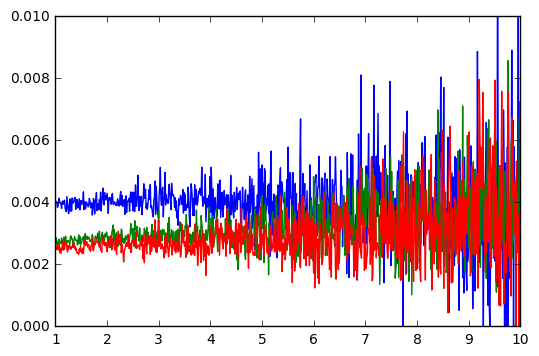

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in divide


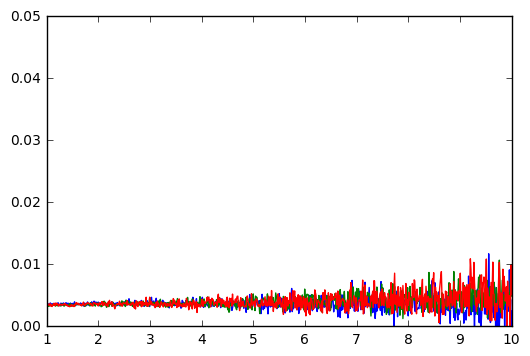

In [243]:
print Cal1[0]
print Cal2[0]
print Cal3[0]
print Cal1[0][0]/Cal1[0][1],Cal2[0][0]/Cal2[0][1],Cal3[0][0]/Cal3[0][1]

pylab.plot(Cal1[2][2],Cal1[2][0]/Cal1[0][0])
pylab.plot(Cal2[2][2],Cal2[2][0]/Cal2[0][0])
pylab.plot(Cal3[2][2],Cal3[2][0]/Cal3[0][0])
pylab.show()

pylab.plot(Cal1[2][2],Cal1[2][1]/Cal1[0][1])
pylab.plot(Cal2[2][2],Cal2[2][1]/Cal2[0][1])
pylab.plot(Cal3[2][2],Cal3[2][1]/Cal3[0][1])
pylab.show()

pylab.plot(Cal1[2][2],(Cal1[2][1]/Cal1[2][0])*(Cal1[0][0]/Cal1[0][1]))
pylab.plot(Cal2[2][2],(Cal2[2][1]/Cal2[2][0])*(Cal2[0][0]/Cal2[0][1]))
pylab.plot(Cal3[2][2],(Cal3[2][1]/Cal3[2][0])*(Cal3[0][0]/Cal3[0][1]))
pylab.axis([1,10,0,0.01])
pylab.show()

K1 = np.nanmedian((0.00366/(Cal1[2][1]/Cal1[2][0])))
K2 = np.nanmedian((0.00366/(Cal2[2][1]/Cal2[2][0])))
K3 = np.nanmedian((0.00366/(Cal3[2][1]/Cal3[2][0])))


pylab.plot(Cal1[2][2],K1*(Cal1[2][1]/Cal1[2][0]))
pylab.plot(Cal2[2][2],K2*(Cal2[2][1]/Cal2[2][0]))
pylab.plot(Cal3[2][2],K3*(Cal3[2][1]/Cal3[2][0]))
pylab.axis([1,10,0,0.05])
pylab.show()

In [66]:
Cpar =  331077.319291 /std =  21207.0732497 Cper =  2428318.65784 /std =  816402.273351 Cpar/Cper =  0.136340145566
Cpar =  337426.257255 /std =  9169.08627914 Cper =  2197662.30654 /std =  373970.868415 Cpar/Cper =  0.153538719871

1.0010188987384854